**PROBLEM**

The task is to create a predictive model for classifying text as positive, neutral, or negative (1, 0 or -1), using **only** the given dataset and without using any pretrained models.

**APPROACH**


**ARCHITECTURE**

After experimenting with various architectures, I have settled on the following:
1. (Optional) Static (non-trainable) GloVe embedding function that gives a stacked tensor of 100 dimensional word embeddings of the input sentence (padded or truncated to 64 words).
2. Stacked LSTM with 8 LSTM layers 
3. Linear layer with softmax that outputs probabilities for the 3 classes
4. (Optional) Max layer that outputs the corresponding predicted goldlabel

This configuration was trained for ~50 epochs on CPU alone (each epoch took around 2 minutes only). It is considerably faster and less resource intensive than  a transformer implementation and gives comparable results.



**TRAINING**

Since converting sentences to embedding representations for each sentence in the train set in every epoch would have been time-consuming, I solved this issue by preprocessing training sentences into embedding tensors using the aforementioned function beforehand and saving it in a DataLoader. I also converted the training set goldlabels into one hot vectors that could directly be passed into the Cross Entropy loss function. This led to a very efficient training process that was carried out on CPU in less than two hours.

The Adam optimiser, was initially used with default settings. In later iterations, it had stopped showing much improvement and decreasing the learning rate showed better results. 
The initial loss was approximately 1.1 and after training it stood at 0.744.




**PERFORMANCE**

It achieved an F1 score of 0.656 on the given validation dataset, compared to the highest achieved score of 0.677.


IMPORTS AND DOWNLOADS

ALL SHOULD BE RUN FOR INFERENCE

In [ ]:
# Data and files are being stored in Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# Importing libraries and packages

import os
import urllib

from __future__ import unicode_literals, print_function, division

from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


import spacy
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Importing Spacy tokeniser

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizer = nlp.tokenizer


In [2]:
# Download GloVe embedding vectors

from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100)


.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]


HTTPError: HTTP Error 403: Forbidden

PREPROCESSING

In [ ]:
# Load training data csv as Pandas dataframe

import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/datasets/train.csv")

In [ ]:
# replacing "\n" with " " for uniformity

def replace_newlines_with_spaces(text):
    return text.replace('\n', ' ')

df['sentence'] = df['sentence'].apply(replace_newlines_with_spaces)


EXPLORATORY ANALYSIS

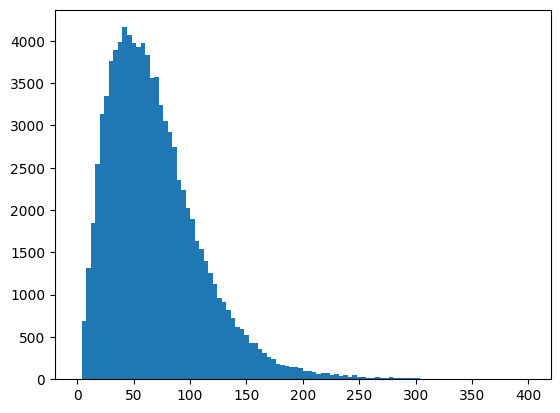

In [ ]:
# visualising sentence character length



lengths = [len(sentence) for sentence in df["sentence"]]

plt.hist(lengths, bins = 100, range = (0,400))
plt.show()

In [ ]:
# most commonly occurring words 

import pandas as pd
from collections import Counter


def process_chunk(chunk):

    all_text = ' '.join(chunk['sentence'])
    words = all_text.split()


    word_counts = Counter(words)

    return word_counts

file_path = '/content/gdrive/My Drive/datasets/test.csv'
chunk_size = 10000


all_word_counts = Counter()


for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk_word_counts = process_chunk(chunk)
    all_word_counts.update(chunk_word_counts)


most_common_words = all_word_counts.most_common(10)

print(most_common_words) 


[('the', 2676), ('I', 2116), ('and', 1996), ('to', 1839), ('a', 1755), ('was', 1060), ('of', 927), ('for', 852), ('in', 743), ('my', 668)]


In [ ]:
# vocabulary size
len(all_word_counts)

12029

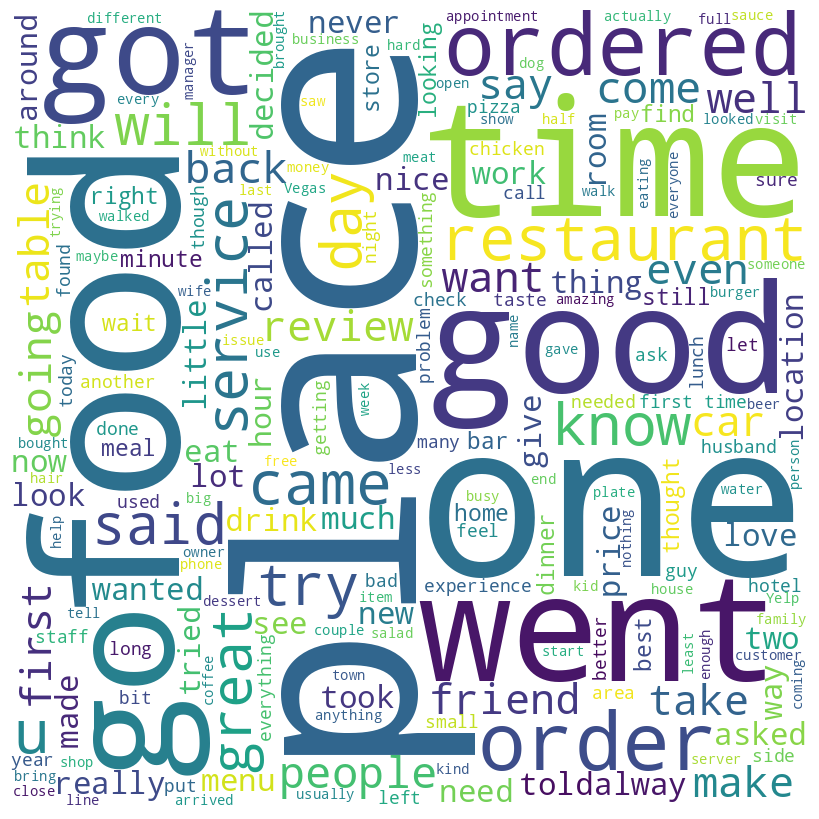

In [ ]:
from wordcloud import WordCloud

text = list(df['sentence'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
wordcloud.generate(' '.join(text))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()


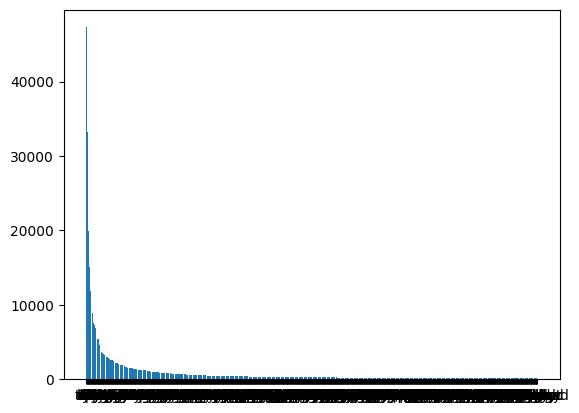

In [ ]:
# word occurrences

cnt = all_word_counts.most_common(10000)

x= [i[0] for i in cnt]
y = [j[1] for j in cnt]

plt.bar(x, y)
plt.show()

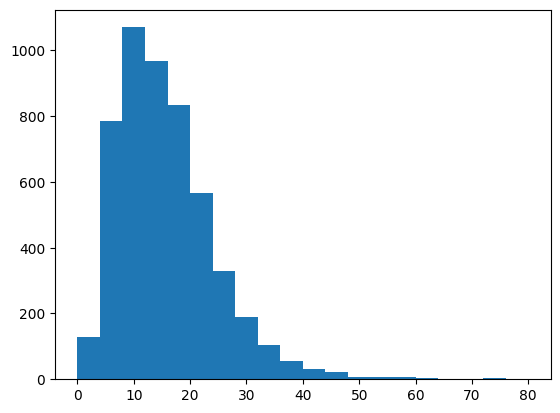

In [ ]:
# sentence lengths
lengths = [ len(tokenizer(sentence)) for sentence in df["sentence"]]

plt.hist(lengths, bins = 20, range = (0,80))
plt.show()

TRAIN SET PREPROCESSING

In [ ]:
# TO RUN FOR INFERENCE
max_len = 64

In [ ]:
# TO RUN FOR INFERENCE
# function to give sentence embedding tensor

def embed(sentence):
  
  tok = tokenizer(sentence.lower()) # tokenization


  if len(tok) >= max_len:  # truncation
    tok = tok[1:max_len + 1]
  
  pad = max_len - len(tok)

  output = []
    
  for i in range(len(tok)):
    if not(tok[i].text in glove.stoi):
        pad = pad+1

    else:
      word_embedding = glove.vectors[glove.stoi[tok[i].text]]
      output.append(word_embedding)
  
  for i in range(pad): # padding
      output.append(torch.zeros(100))
  
  return torch.stack(output)



In [ ]:
# building train set of sentence embeddings and label tensors

train_set = []

for line in tqdm(df.itertuples(), total=len(df)):
  text = line[2]
  label = line[3]
  label = torch.eye(3)[label+1] # gold label converted to one hot
  train_set.append((embed(text),label))


inputs = []
labels = []
for x in train_set:
    input_tensor = x[0]
    label_tensor = torch.tensor(x[1])
    inputs.append(input_tensor)
    labels.append(label_tensor)

inputs = torch.stack(inputs)
labels = torch.stack(labels)

In [ ]:
# check dimensions
print(inputs.shape)

torch.Size([92228, 64, 100])


In [ ]:
# Create a TensorDataset object from inputs and labels
dataset = TensorDataset(inputs, labels)

# Create a DataLoader from the dataset
train_loader = DataLoader(dataset, batch_size=32)

In [ ]:
device = torch.device("cpu")

In [ ]:
torch.save(train_loader, "/content/gdrive/My Drive/loder.pth")

NameError: ignored

MODEL

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim = 100, hidden_dim = 32, num_layers =8, output_dim = 3, batch_size=32):
        super(LSTMModel, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 

        self.hidden = self.init_hidden()


    def forward(self, text, pro = False, predict = False, batched = True):
        

        if pro:
          text = embed(text)
        
        if batched:
          (h0, c0) = self.hidden
        else:
          h0 = torch.zeros(self.num_layers, self.hidden_dim)
          c0 = torch.zeros(self.num_layers, self.hidden_dim)

        output, (hn, cn) = self.lstm(text, (h0, c0))

        final_hidden = hn[-1, :]
        out = self.fc(final_hidden)
        out = F.softmax(out, -1)


        if predict == False:
          return out
        else:
          return torch.argmax(out) - 1

    def init_hidden(self):
      h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
      c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

      return (h0, c0)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim = 100, hidden_dim = 32, num_layers =8, output_dim = 3, batch_size=32):
        super(LSTMModel, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 

        self.hidden = self.init_hidden()


    def forward(self, text, pro = False, predict = False, batched = True):
        

        if pro:
          text = embed(text)
        
        if batched:
          (h0, c0) = self.hidden
        else:
          h0 = torch.zeros(self.num_layers, self.hidden_dim)
          c0 = torch.zeros(self.num_layers, self.hidden_dim)

        output, (hn, cn) = self.lstm(text, (h0, c0))

        final_hidden = hn[-1, :]
        out = self.fc(final_hidden)
        out = F.softmax(out, -1)


        if predict == False:
          return out
        else:
          return torch.argmax(out) - 1

    def init_hidden(self):
      h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
      c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

      return (h0, c0)

In [ ]:
# TO RUN FOR INFERENCE

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim = 100, hidden_dim = 32, num_layers =8, output_dim = 3, batch_size=32):
        super(LSTMModel, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        


    def forward(self, text, pro = False, predict = False, batched = True):
        

        if pro:
          text = embed(text)
        


        if batched:
          (h0, c0) = self.init_hidden(1)  
          
        else:
          h0, c0 = self.init_hidden(1)  
          h0 = torch.zeros(self.num_layers, self.hidden_dim)
          c0 = torch.zeros(self.num_layers, self.hidden_dim)
          

        output, (hn, cn) = self.lstm(text, (h0, c0))

        final_hidden = hn[-1, :]
        out = self.fc(final_hidden)
        out = F.softmax(out, -1)


        if predict == False:
          return out
        else:
          return torch.argmax(out) - 1

    def init_hidden(self, batch_size):
      h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
      c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)

      return (h0, c0)


TRAINING

In [ ]:
# load preprocessed DataLoader from Drive
train_loader = torch.load("/content/gdrive/My Drive/loder.pth") # max_len = 64

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    # move data and target to device
    data = data.to(device)
    target = target.to(device)

In [ ]:
dataset = TensorDataset(data, target)
train_loader= DataLoader(dataset)

In [ ]:
# Loading model from stored weights

model = LSTMModel()
#model.to(device)
model.load_state_dict(torch.load("/content/gdrive/My Drive/LSTM.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:

model = torch.load("/content/gdrive/My Drive/LSTM_AdamW.pt")
#model.to(device)
#model.load_state_dict(torch.load("/content/gdrive/My Drive/LSTM_AdamW.pth", map_location=device))


In [ ]:
model = LSTMModel()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 8e-4)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 5e-4)

In [ ]:
optimizer = optim.RMSprop(model.parameters())

In [ ]:
optimizer = optim.AdamW(model.parameters(),lr = 4e-5)

In [ ]:
optimizer = optim.Adagrad(model.parameters(),lr = 0.0005)

In [ ]:
device = torch.device("cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    j =0

    iterator = tqdm(iterator, desc="Training")

    for batch in iterator:
        j = j+1
        text, label = batch

        optimizer.zero_grad()
        predictions = model(text)


        loss = criterion(predictions, label)


        rounded_preds = torch.eye(3)[torch.argmax(predictions, dim =1)]
        correct = (rounded_preds == label).float()
        acc = correct.sum() / len(correct)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # Debugging: Check that the optimizer is updating the model's parameters
      #  print(f"First layer weight grad: {model.lstm.weight_ih_l0.grad[0, 0]}, optimizer state: {optimizer.state_dict()['state'][model.lstm.weight_ih_l0]['step']}")
        iterator.set_postfix(loss=epoch_loss/j)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
#train_loader2 = torch.load("/content/gdrive/My Drive/train_loader.pth") # max_len = 25 (used initially)

In [ ]:
# test model functioning

model("it is a bit disheartening how", pro = True, batched = False) # for obtaining labels set predict = True

tensor([1.0000e+00, 1.9116e-07, 2.3897e-08], grad_fn=<SoftmaxBackward0>)

In [ ]:
model = torch.load("/content/gdrive/My Drive/LSTM_AdamW.pt")

AttributeError: ignored

In [ ]:
# training for 10 epochs

for i in range(10):
    try:
        train(model, train_loader, optimizer, criterion)
        
    except Exception as e:
        continue



Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0008
    maximize: False
    weight_decay: 0
)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
! export MKLDNN_ENABLED=0 
! USE_MKLDNN=0 

python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [ ]:
torch.backends.mkldnn.enabled = False

In [ ]:
train(model, train_loader, optimizer, criterion)

Training:   0%|          | 0/2883 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# save model weights
torch.save(model, "/content/gdrive/My Drive/LSTM_AdamW.pt") 

In [ ]:
model = torch.load()

NameError: ignored

MODEL INFERENCE ON VALLIDATION/TEST SET

In [ ]:
# Read validation set csv

import pandas as pd

df2 = pd.read_csv("/content/gdrive/MyDrive/datasets/test.csv")

In [ ]:
df2.head()

,text_id,sentence
0,r1-0086521,A helpful valet at the Bellagio said it was a ...
1,r1-0044715,"People often ask ""what happened to the human c..."
2,r1-0060690,He explained there would be a diagnostic fee o...
3,r1-0016852,I had initially purchased a massage on Groupon.
4,r2-0006040,Primarily do high-end cars as they get referra...


In [ ]:
max_len = 64

In [ ]:
# Initialise an empty list and add predicted labels to it

preds = []

for num, i  in tqdm(enumerate(df2.itertuples())):
  pred = model(i[2], pro = True, batched = False, predict = True)
  preds.append(pred)


0it [00:00, ?it/s]

In [ ]:
# examine labels

preds[0:5]

[tensor(1), tensor(0), tensor(0), tensor(0), tensor(-1)]

In [ ]:
# write the list into a file in drive and download it

from google.colab import files
my_list = [x.item() for x in preds]

my_string = '\n'.join(str(x) for x in my_list)

# Write string to file

with open('/content/gdrive/My Drive/answer.txt', 'w') as f:
    f.write(my_string)

files.download('/content/gdrive/My Drive/answer.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>